# Classification

In [37]:
#Import libraries
import pandas as pd
import numpy as np

from scipy.stats import poisson
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [4]:
#Load dataset
claims_df = pd.read_csv('claims_data.csv')
claims_df.head()

,age,sex,bmi,steps,children,smoker,region,insurance_claim,claim_amount
0,19,female,27.900,3009,0,yes,southwest,yes,16884.9240
1,18,male,33.770,3008,1,no,southeast,yes,1725.5523
2,28,male,33.000,3009,3,no,southeast,no,0.0000
3,33,male,22.705,10009,0,no,northwest,no,0.0000
4,32,male,28.880,8010,0,no,northwest,yes,3866.8552


In [8]:
# Percentage of people classifed as overweight (BMI > 25)
overweight_proportion = (claims_df['bmi'] > 25).mean() * 100
print(overweight_proportion)

81.53961136023916


In [11]:
columns = claims_df.columns
print(columns)

Index(['age', 'sex', 'bmi', 'steps', 'children', 'smoker', 'region',
       'insurance_claim', 'claim_amount'],
      dtype='object')


In [20]:
#Calculate the poisson Parameter (λ)
lambda_ = claims_df['children'].mean()
variance = claims_df['children'].var()
print(lambda_, variance)

1.0949177877429 1.453212745666905


In [14]:
#Create a Poisson distribution with λ = mean children
poisson_dist = poisson(mu=lambda_)

# Generate theoretical probabilities for k=0,1,2,...,max_children
max_children = claims_df['children'].max()
k_values = np.arange(0, max_children + 1)
pmf_values = poisson_dist.pmf(k_values)  # Probability Mass Function

# Predict the number of people aged 60 and older and then compare to the actual number of people aged 60 and older

In [26]:
#Calculate the mean and standard deviation of the ages
mean_age = claims_df['age'].mean()
std_age = claims_df['age'].std()

#Probabilit(X >= 60)
prob_60_plus = norm.sf(60, loc=mean_age, scale=std_age)

#Expected count
expected_60_plus = prob_60_plus * len(claims_df)

#Get actual count
actual_60_plus = (claims_df['age'] >= 60).sum()

print(expected_60_plus, actual_60_plus)

92.9184876682198 114


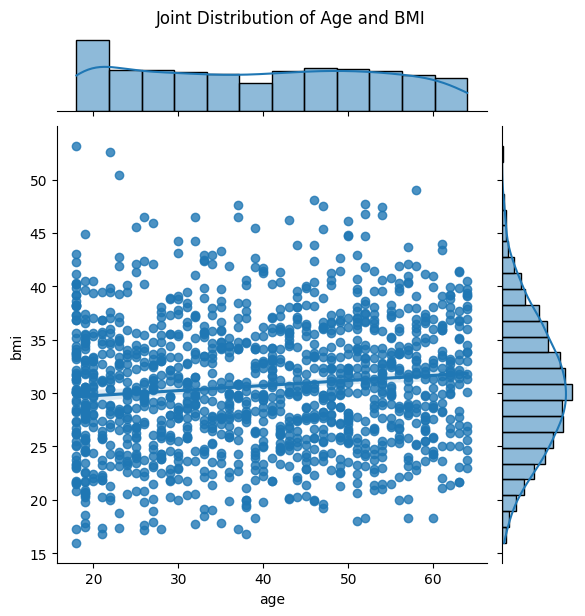

In [36]:
# Create joint plot
sns.jointplot(
    data=claims_df,
    x='age',
    y='bmi',
    kind='reg'
)

plt.suptitle("Joint Distribution of Age and BMI", y=1.02)
plt.show()

# Predict insurance claim using Logistic Regression

In [40]:
#Convert target to binary (0/1)
claims_df['insurance_claim'] = claims_df['insurance_claim'].map({'yes': 1, 'no': 0})

#Separate features and target
X = claims_df.drop(columns=['insurance_claim', 'claim_amount'])
y = claims_df['insurance_claim']

#Identify categorical columns
categorical_cols = X.select_dtypes(include = ['object', 'category']).columns.tolist()

#Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder = 'passthrough'
)

#Create a full pipeline with logistic regression
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

#Split the data (33% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

#Fit the model
model.fit(X_train, y_train)

#Generate predictions for the test set
y_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(test_accuracy)

0.8687782805429864


C:\Users\Don\anaconda3\envs\SQL_packages\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
